In [1]:
%run Make_Question_simplified.ipynb
import numpy as np
from collections import defaultdict

import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import csv

In [2]:
N = 2
#M = 5
I = 2
J = 2
K = 3
Data_upperbound = 20
Processing_upperbound = 40


In [3]:
Data_input = Data_Queue(I,J,Data_upperbound)
Data_input_type = Data_Queue_type(I,J,K)
VM_type = VM_Data_type_gen(I,K,N)
VM_speed = VM_Data_processing_speed(Processing_upperbound, VM_type, K)

In [4]:
print(VM_type)
print(Data_input_type)

[[1 3]
 [1 2]]
[[1 2]
 [3 2]]


In [5]:
VM_DP_time = VM_Data_processing_time(Data_input, Data_input_type , VM_speed)
#print(np.shape(VM_DP_time),np.shape( Data_input_type),np.shape(VM_speed))
modified_VM_DP_time =np.copy(VM_DP_time)
modified_VM_DP_time[np.isinf(modified_VM_DP_time)]=100

In [6]:
print(VM_DP_time)
print(modified_VM_DP_time)

[[[ 1.  4.]
  [inf  1.]]

 [[ 3. inf]
  [inf  1.]]]
[[[  1.   4.]
  [100.   1.]]

 [[  3. 100.]
  [100.   1.]]]


In [7]:
T_max = little_greedy_algorithm(VM_DP_time,I,J,N)
print(T_max)

6


In [8]:
print("let t = 1 unit of time")

let t = 1 unit of time


In [9]:
position_dictionary, Total = Make_dictionary(I,J,N,T_max)
QUBO_init = np.zeros((Total, Total))
P = 20

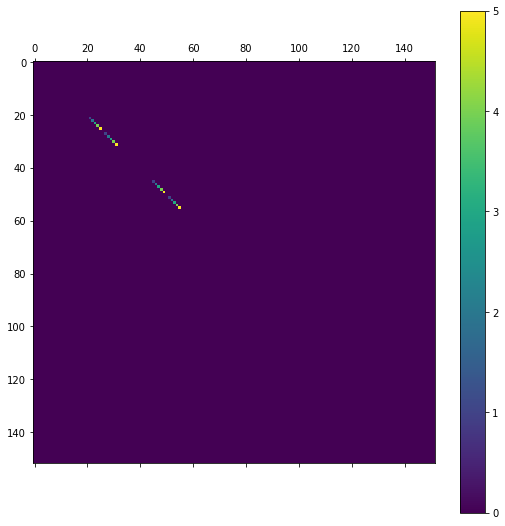

In [10]:
#Obj QUBO dont flatten yet
QUBO_0 = np.zeros_like(QUBO_init)
for i in range(I):    
    for m in range(N):
        for t in range(T_max):
            index_matched = position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)]
            QUBO_0[index_matched,index_matched] += t

#print(QUBO)
show_graph(QUBO_0)

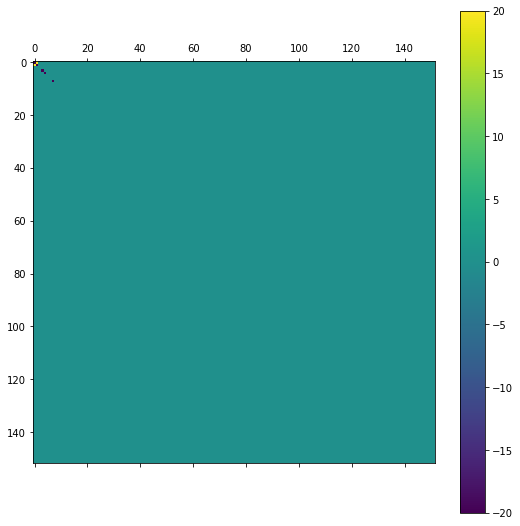

In [12]:
#C1 line(3)
P1 = np.ones((I,J)) * P
QUBO_1 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        index_matched = [];
        for machine in V_ij_k:
            index_matched.append(position_dictionary['x_%d%d%d'%(i,j,machine)])
        #print(V_ij_k)
        x_matched = np.zeros(Total)
        x_matched[np.array(index_matched)] = 1
        QUBO_1 += P1[i,j]* (1 * np.outer(x_matched,x_matched) - 2*np.diag(x_matched))

show_graph(QUBO_1)

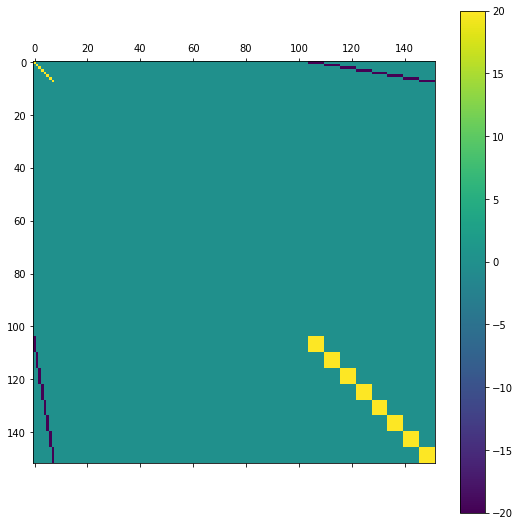

In [33]:
#C2 line(4)
P2 = np.ones((I,J,N)) * P
QUBO_2 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            index_matched_z = []
            index_matched_x = []
            index_matched_x.append(position_dictionary['x_%d%d%d'%(i,j,m)])
            for t in range(T_max):
                index_matched_z.append(position_dictionary['z_%d%d%d%d'%(i,j,m,t)])
            #print(index_matched)
            var_matched = np.zeros(Total)
            var_matched[np.array(index_matched_z)] = 1
            var_matched[np.array(index_matched_x)] = -1
            QUBO_2 += P2[i,j,m]*np.outer(var_matched,var_matched)

show_graph(QUBO_2)

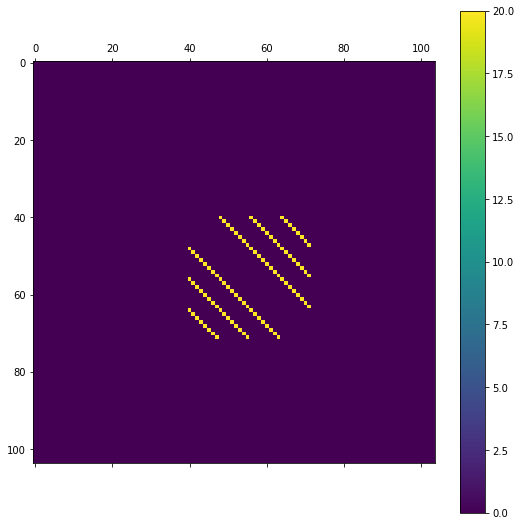

In [220]:
#C3 line(5)
P3 = np.ones((N,T_max)) * P
QUBO_3 = np.zeros_like(QUBO_init)
for m in range(N):
    for t in range(T_max):
        index_matched = [];
        for i in range(I):
            for j in range(J):
                index_matched.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
        #print(index_matched)
        var_matched = np.zeros(Total)
        var_matched[np.array(index_matched)] = 1
        QUBO_3 += P3[m,t]*(np.outer(var_matched,var_matched)-np.diag(var_matched))

show_graph(QUBO_3)

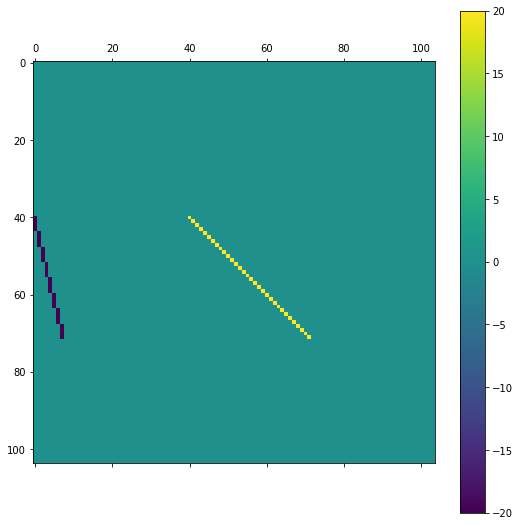

In [221]:
#C4 line(6)
P4 = np.ones((I,J,N,T_max)) * P
QUBO_4 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                QUBO_temp = np.zeros_like(QUBO_init)
                index_matched_x = position_dictionary['x_%d%d%d'%(i,j,m)]
            
                index_matched_y = position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                #print(index_matched)
                QUBO_temp[index_matched_y,index_matched_y] = 1 
                QUBO_temp[index_matched_y,index_matched_x] = -1 
                QUBO_4 += P4[i,j,m,t]*QUBO_temp

show_graph(QUBO_4)

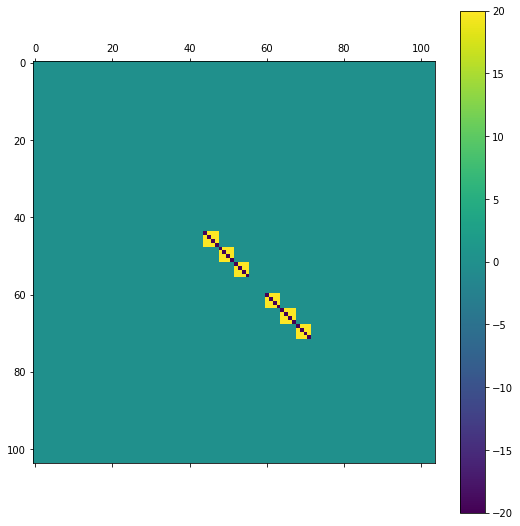

In [222]:
#C5 line(7)
P5 = np.ones((I,J,N)) * P
QUBO_5 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        for machine in V_ij_k:
            index_matched_y = []
            for t in range(T_max):
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,machine,t)])
                
            var_matched = np.zeros(Total)
            #print(modified_VM_DP_time[i,j,m] )
            #print(index_matched_y)
            var_matched[np.array(index_matched_y)] = 1
            QUBO_5 += P5[i,j,machine]*( np.outer(var_matched,var_matched) - np.diag(var_matched) - modified_VM_DP_time[i,j,machine] * np.diag(var_matched))


show_graph(QUBO_5)

In [223]:
print(modified_VM_DP_time) 

[[[100.   1.]
  [  1.   1.]]

 [[100.   1.]
  [  1.   1.]]]


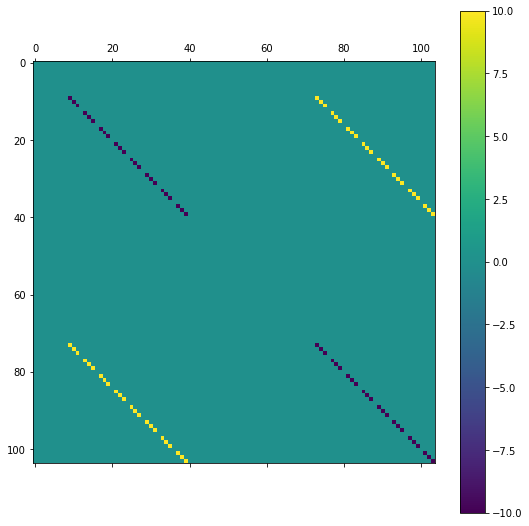

In [224]:
#C6 line(8)
P6 = np.ones((I,J,N,T_max)) * P
QUBO_6 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(1,T_max):
                index_matched_z =  position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                index_matched_p =  position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                
                var_matched = np.zeros(Total)

                var_matched[index_matched_z ] = 1
                var_matched[index_matched_p ] = 1
                
                QUBO_6 += P6[i,j,m,t]*(0.5*np.outer(var_matched,var_matched)-np.diag(var_matched))


show_graph(QUBO_6)

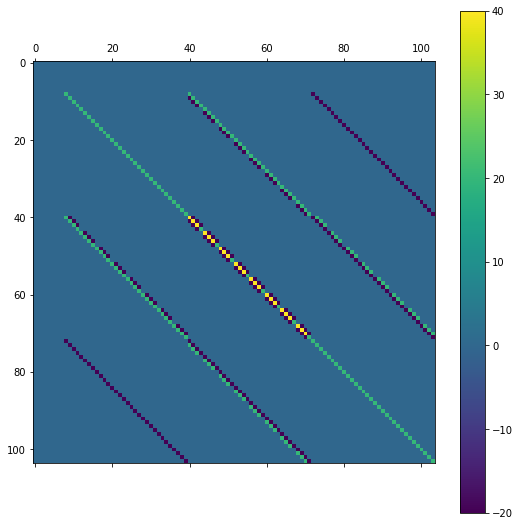

In [225]:
#C7 line(9)
P7 = np.ones((I,J,N,T_max)) * P
QUBO_7 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                if t>0:
                    index_matched_y_pre =  position_dictionary['y_%d%d%d%d'%(i,j,m,t-1)]
                index_matched_y =  position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                index_matched_z =  position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                index_matched_p =  position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                
                var_matched = np.zeros(Total)
                
                if t>0:
                    var_matched[index_matched_y_pre] = 1
                var_matched[index_matched_y] = -1
                var_matched[index_matched_z ] = 1
                var_matched[index_matched_p ] = -1
                
                QUBO_7 += P7[i,j,m,t]*np.outer(var_matched,var_matched)


show_graph(QUBO_7)
                #show_graph(np.outer(var_matched,var_matched))

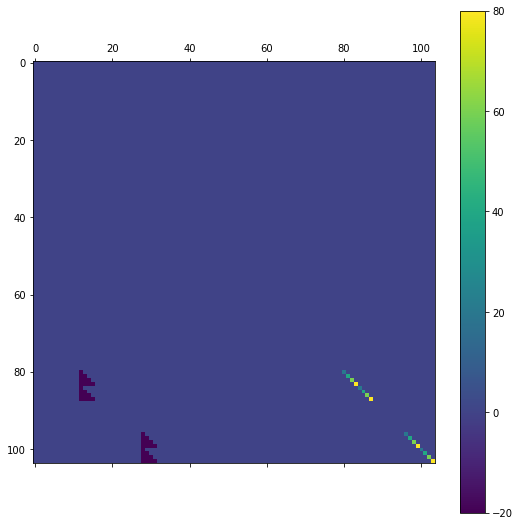

In [226]:
#C9 line(11)
P8 = np.ones((I,J,N,T_max,T_max)) * P
QUBO_8 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J-1):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        for machine in V_ij_k:
            for t in range(T_max):
                for t_prime in range(t,T_max):
                    V_ijplus1_k, _ = np.where(VM_type == Data_input_type[i,j+1])
                    for machine_prime in V_ijplus1_k:
                        
                        QUBO_temp = np.zeros_like(QUBO_init)
                        
                        index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j+1,machine_prime,t_prime)]

                        index_matched_p = position_dictionary['p_%d%d%d%d'%(i,j,machine,t)]
                        #print(index_matched)
                        QUBO_temp[index_matched_z,index_matched_z] = 1 
                        QUBO_temp[index_matched_z,index_matched_p] = -1 
                        QUBO_8 += P8[i,j,machine,t,t_prime]*QUBO_temp

show_graph(QUBO_8)

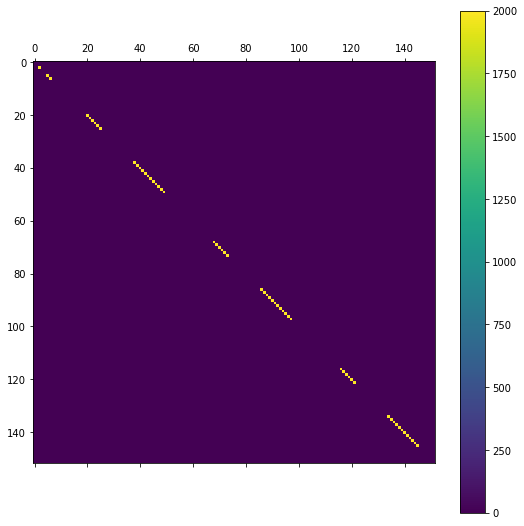

In [14]:
#C add line(##)
P_add = 2000 
QUBO_add = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        All_VM = np.arange(N)
        diff_VM = np.setdiff1d(All_VM,V_ij_k)
        #print(V_ij_k)
        #print(diff_VM )
        for machine in diff_VM :
            index_matched_x = position_dictionary['x_%d%d%d'%(i,j,machine)]
            QUBO_add[index_matched_x,index_matched_x] = P_add
            for t in range(T_max):
                index_matched_p = position_dictionary['p_%d%d%d%d'%(i,j,machine,t)]
                index_matched_y = position_dictionary['y_%d%d%d%d'%(i,j,machine,t)]
                index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j,machine,t)]
                QUBO_add[index_matched_p,index_matched_p] = P_add
                QUBO_add[index_matched_y,index_matched_y] = P_add
                QUBO_add[index_matched_z,index_matched_z] = P_add
                
                
               
show_graph(QUBO_add)

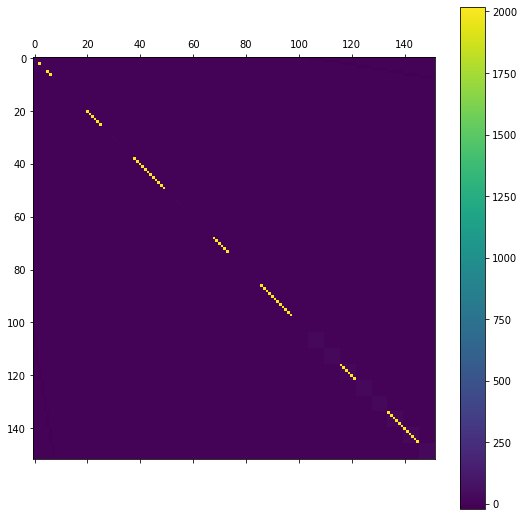

In [34]:
QUBO = np.zeros_like(QUBO_init)
QUBO = QUBO_0 + QUBO_add + QUBO_1 + QUBO_2 #+ QUBO_3 + QUBO_4 + QUBO_5 + QUBO_6 + QUBO_7 + QUBO_8 + QUBO_add
show_graph(QUBO) 

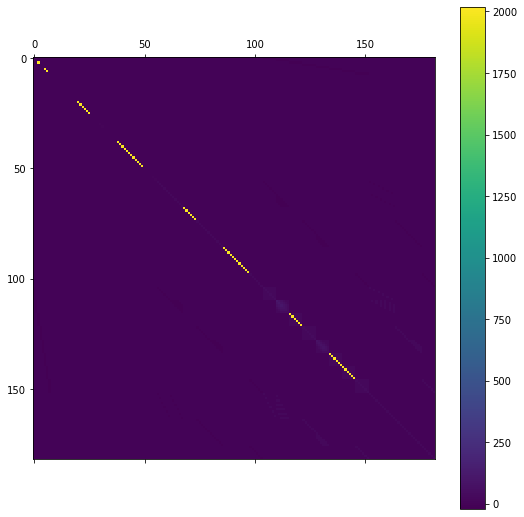

In [35]:
## Single Slack Variable part
#C8 line(10)

constraint = 9
P9 = np.ones((I,J,N,T_max)) * P
for i in range(I):
    for j in range(J):
        for t in range(T_max):
            V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
            for machine in V_ij_k:
            
                index_matched_y = []
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,machine,t)])                
                
                alpha = 0
                index_matched_z = []
                for alpha in range(1,int(modified_VM_DP_time[i,j,machine])+1):
                    index_matched_z.append(position_dictionary['z_%d%d%d%d'%(i,j,machine,max(t-alpha+1,0))])
                
                #slack var
                #print(index_matched_z,index_matched_y)

    
                position_dictionary["s_%d_%d%d%d%d"%(constraint,i,j,machine,t)] = Total
                Total += 1
                
                QUBO = np.pad(QUBO, [(0, 1), (0, 1)], mode='constant', constant_values = 0)
                #print(np.shape(QUBO))
                #
                
                #print(len(position_dictionary))
                var_matched = np.zeros(Total)
                var_matched[index_matched_y] = -1
                var_matched[np.unique(index_matched_z)] = 1
                var_matched[-1] = 1
                QUBO += P9[i,j,machine,t]*np.outer(var_matched,var_matched)
                
show_graph(QUBO) 

In [36]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import numpy as np
import dwave.inspector
import dimod

import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt

In [37]:
#from dwave.system import LeapHybridSampler
width,height = np.shape(QUBO)

QUBO_dictionary = defaultdict(int)
for i in range(width):
    for j in range(height):
        QUBO_dictionary[(i,j)] = QUBO[i,j]

# Select a solver
#sampler = LeapHybridSampler()



# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
#chainstrength = 8
#numruns = 3  #Max =1e4 , a Complex problem needs more numruns 

#response = sampler.sample_qubo(QUBO)


#dwave_sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
#bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
#sampleset = dwave_sampler.sample(bqm, num_reads=1000)



#sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6'))
#response = sampler.sample_qubo(QUBO_dictionary, chain_strength=chainstrength, num_reads=numruns)


In [38]:
'''
import hybrid
workflow = hybrid.Loop(
   hybrid.RacingBranches(
      hybrid.InterruptableTabuSampler(),
      hybrid.EnergyImpactDecomposer(size=30, rolling=True, rolling_history=0.75)
      | hybrid.QPUSubproblemAutoEmbeddingSampler()
      | hybrid.SplatComposer()) | hybrid.ArgMin(), convergence=3)
bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
result = hybrid.HybridSampler(workflow).sample(bqm)  
'''
#print("Solution: sample={}".format(result.first)) 

c = 1

In [39]:
import dwave.inspector
sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))

num_reads = 10000
sampleset = sampler.sample_qubo(QUBO, num_reads=num_reads)

In [40]:
print(sampleset)

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 181 energy num_oc. ...
8     1  0  0  1  1  0  0  1  1  0  0  1  1  1  1  0 ...   0   96.0       1 ...
6483  1  0  0  1  1  0  0  1  0  1  1  1  1  0  1  1 ...   1  120.0       1 ...
3352  1  0  0  1  1  0  0  1  1  1  0  0  1  1  1  1 ...   1  132.0       1 ...
416   0  1  0  1  1  0  0  1  1  1  1  0  0  1  0  0 ...   0  133.0       1 ...
2990  1  1  0  0  1  0  0  1  0  1  1  0  1  0  1  0 ...   1  147.0       1 ...
2108  0  1  0  1  1  0  0  1  1  1  0  0  0  1  0  1 ...   0  148.0       1 ...
5791  1  0  0  1  1  0  0  1  0  0  0  0  1  0  0  1 ...   1  148.0       1 ...
1114  0  1  0  1  1  0  0  1  1  0  0  0  0  0  0  1 ...   1  154.0       1 ...
4308  1  1  0  1  1  0  0  1  1  1  0  0  1  0  1  0 ...   0  154.0       1 ...
184   1  1  0  1  1  0  0  1  1  0  1  1  0  0  0  0 ...   1  155.0       1 ...
323   0  1  0  1  1  0  0  1  1  0  1  1  0  1  0  1 ...   1  157.0       1 ...
5274  1  1  0  1  1  0  0  1  1  1  1  0

In [41]:
sample = sampleset.first.sample
energy = sampleset.first.energy
print(sample,energy)

{0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 1, 28: 1, 29: 0, 30: 1, 31: 0, 32: 0, 33: 1, 34: 1, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 1, 51: 1, 52: 0, 53: 1, 54: 0, 55: 1, 56: 0, 57: 1, 58: 1, 59: 1, 60: 0, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 1, 76: 1, 77: 0, 78: 1, 79: 0, 80: 1, 81: 1, 82: 1, 83: 0, 84: 0, 85: 1, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 1, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

In [42]:
vals = np.fromiter(sample.values(), dtype=int)

In [43]:
vals

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0])

In [44]:
keys=vals[:I*J*N]
answer = keys.reshape([I,J,N])

print(answer)

[[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]


In [45]:
print(np.sum(answer,(0,1)))

[2 2]


In [46]:
print(VM_type)


[[1 3]
 [1 2]]


In [47]:
print(Data_input_type)

[[1 2]
 [3 2]]


In [48]:
sampleset.second

AttributeError: 'SampleSet' object has no attribute 'second'

In [278]:
#dir(sampleset)

In [245]:
OP = sampleset.to_pandas_dataframe()

In [246]:
OP

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,chain_break_fraction,energy,num_occurrences
0,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0.210938,599.0,1
1,0,1,1,0,0,1,1,0,0,0,...,1,0,0,0,0,1,1,0.203125,486.0,1
2,0,1,1,1,0,1,0,1,0,0,...,0,1,1,1,1,1,0,0.226562,750.0,1
3,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0.203125,995.0,1
4,0,1,0,1,0,1,1,0,0,0,...,1,1,1,1,0,0,1,0.234375,571.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,1,0,1,1,1,0,0,...,1,1,1,1,1,0,1,0.343750,1342.0,1
9996,0,1,1,1,0,1,0,1,0,0,...,1,1,1,1,1,1,0,0.359375,1422.0,1
9997,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0.359375,1327.0,1
9998,0,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0.359375,1334.0,1


In [249]:
import pandas as pd

In [257]:
OP = OP.sort_values("energy")
OP

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,chain_break_fraction,energy,num_occurrences
5444,0,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0.296875,361.0,1
6671,0,1,0,1,0,1,0,1,0,0,...,0,1,0,0,0,1,1,0.335938,362.0,1
769,0,1,0,1,0,1,0,1,0,0,...,1,0,1,0,1,1,1,0.273438,366.0,1
1322,0,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0.296875,369.0,1
1387,0,1,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0.304688,380.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9734,0,0,1,1,0,1,1,1,0,0,...,0,1,1,1,1,0,1,0.343750,2067.0,1
8117,0,1,0,1,0,1,1,1,0,0,...,0,0,0,1,0,1,1,0.281250,2694.0,1
9365,0,1,1,1,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0.281250,2783.0,1
9812,0,1,1,0,0,1,1,1,0,0,...,1,1,1,0,1,1,0,0.296875,2908.0,1


In [258]:
OP_final = OP.to_numpy()

In [264]:
OP_opt = OP_final[1,:].flatten()

In [272]:
op_opt = OP_opt.astype(int)

In [275]:
op_opt[0]

0

In [277]:
keys = op_opt[:I*J*N]
print(keys)
answer = keys.reshape([I,J,N])

print(answer)

[0 1 0 1 0 1 0 1]
[[[0 1]
  [0 1]]

 [[0 1]
  [0 1]]]


In [279]:
print(VM_type)

[[1 3]
 [1 2]]


In [280]:
print(Data_input_type)

[[2 1]
 [2 1]]
